# League of Legends Gameplay Audit: Data-Driven Climbing Strategy
### Análisis Estadístico y mejora del Rendimiento Personal
---

**👤 Autor:** Tomás Moreira  
**📅 Fecha de Última Actualización:** 29 de Noviembre, 2025  
**🎯 Objetivo:** Optimización de Win Rate y Auditoría de Gameplay  
**🔗 Contacto:** [https://www.linkedin.com/in/tomas-moreira/]  | tomasmoreira.r@gmail.com 

---

# Objetivos del proyecto

Realizar una **auditoría estadística y predictiva** del rendimiento personal en *League of Legends*. Mediante:

1.  **Análisis Inferencial (EDA):** Para identificar ineficiencias tácticas (gestión de oro, visión, champion pool) y desmitificar patrones del matchmaking mediante validación estadística.
2.  **Machine Learning:** Para entrenar modelos supervisados capaces de **clasificar resultados y predecir victorias**, determinando matemáticamente qué variables (features) tienen mayor peso predictivo en el desenlace de la partida.

# Diccionario de Datos: Estructura del Dataset

Este proyecto utiliza datos extraídos de la **Riot Games API**. El dataset contiene registros a nivel de jugador por partida (Flexible y Solo Q). Las features son las siguientes:

### 1. Identificadores y Contexto
| Columna | Descripción |
| :--- | :--- |
| `match_id` | Identificador único de la partida en el servidor (ej: `LA2_152...`). |
| `queue_id` | Tipo de cola clasificatoria. Categorías: **420** (Solo/Duo Queue), **440** (Flex Queue). |
| `game_duration` | Duración total de la partida (float). |

### 2. Variables Categóricas
| Columna | Descripción |
| :--- | :--- |
| `win` | **Variable Objetivo (Target).** Etiquetas: **1** (Victoria), **0** (Derrota). |
| `champion` | Nombre del campeón utilizado por el jugador. |
| `role` | Posición asignada y jugada. Categorías: `TOP`, `JUNGLE`, `MIDDLE`, `BOTTOM`, `UTILITY` (Soporte). |

### 3. Métricas de rendimiento (Totales por partida)
| Columna | Descripción |
| :--- | :--- |
| `kills` | Total de asesinatos conseguidos por el jugador. |
| `deaths` | Total de muertes sufridas. |
| `assists` | Total de asistencias en asesinatos del equipo. |
| `lane_minions` | Cantidad de súbditos de línea eliminados. |
| `jungle_minions` | Cantidad de monstruos de jungla eliminados (propios y enemigos). |

### 4. Métricas de Visión
| Columna | Descripción |
| :--- | :--- |
| `vision_score` | Puntuación calculada por Riot que mide la efectividad de la visión proporcionada y denegada. |
| `wards_placed` | Cantidad bruta de centinelas colocados (Totems + Azules + Centinelas). |
| `wards_killed` | Cantidad de centinelas enemigos destruidos. |
| `control_wards_placed` | Cantidad de *Control Wards* (Rosas) colocados. |

### 5. Métricas temporales (Línea de Tiempo: 5, 10 y 15 min)
Estas variables miden el estado de la partida en momentos específicos para evaluar el desempeño en el tiempo.

| Columna (Sufijo) | Descripción |
| :--- | :--- |
| `min[X]_gold` | Oro total acumulado por el jugador al minuto X. |
| `min[X]_cs` | *Creep Score* (Farm) total acumulado al minuto X. |
| `min[X]_gold_diff` | **Diferencial de Oro:** (Oro Jugador - Oro Rival de Línea). Valores positivos indican ventaja económica. |
| `min[X]_xp_diff` | **Diferencial de XP:** (XP Jugador - XP Rival de Línea). Valores positivos indican ventaja de nivel. |
| `min[X]_cs_diff` | **Diferencial de Farm:** (CS Jugador - CS Rival de Línea). Valores positivos indican dominio de línea. |

> **Nota:** `[X]` representa los cortes de tiempo a los **5**, **10** y **15** minutos (ej: `min15_gold_diff`).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from funciones import *

import warnings
warnings.filterwarnings('ignore')

# Carga y Exploración de los datos

In [2]:
# Creamos el set de datos a partir de los datos obtenidos por la Api de RIOT
data_riot_flex = pd.read_csv("raw_flex.csv")
data_riot_soloq = pd.read_csv("raw_soloQ.csv")
data_riot = pd.concat([data_riot_flex, data_riot_soloq], ignore_index=True)
df_base = data_riot.copy()
df_base

,match_id,queue_id,win,champion,role,game_duration,kills,deaths,assists,lane_minions,...,min10_gold,min10_cs,min10_gold_diff,min10_xp_diff,min10_cs_diff,min15_gold,min15_cs,min15_gold_diff,min15_xp_diff,min15_cs_diff
0,LA2_1527080479,440,0,Ezreal,BOTTOM,27.05,2,6,5,164,...,3301.0,50.0,-982,-646,-18,4635.0,89.0,-3045,-1425,-26
1,LA2_1527065732,440,1,Ezreal,BOTTOM,38.75,10,4,10,190,...,4386.0,81.0,1418,311,16,7193.0,114.0,2383,672,15
2,LA2_1527057376,440,1,Ezreal,BOTTOM,28.45,6,2,4,218,...,3211.0,81.0,21,-279,4,5200.0,118.0,821,941,21
3,LA2_1527048075,440,0,Ezreal,BOTTOM,30.10,4,1,5,213,...,3189.0,76.0,-429,-280,-8,4898.0,110.0,-729,-421,-4
4,LA2_1527038523,440,1,Ezreal,BOTTOM,22.57,4,1,5,148,...,3353.0,72.0,-293,435,2,5463.0,103.0,-513,621,-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,LA2_1504933509,420,0,Trundle,TOP,28.32,2,10,3,153,...,2484.0,35.0,-2117,-1382,-39,3527.0,52.0,-3599,-3143,-75
339,LA2_1496670428,420,1,Karma,UTILITY,40.87,4,7,23,50,...,2320.0,11.0,85,33,0,3792.0,17.0,-242,-188,-3
340,LA2_1496663226,420,0,Galio,UTILITY,17.88,0,5,2,25,...,2496.0,17.0,-575,-698,9,3552.0,24.0,-999,-1574,12
341,LA2_1496645695,420,0,Darius,JUNGLE,37.02,6,9,7,62,...,3641.0,68.0,-4,653,19,5346.0,111.0,77,818,40


In [3]:
# Revisar los tipos de datos, nulos, cantidad de registros
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   match_id              343 non-null    object 
 1   queue_id              343 non-null    int64  
 2   win                   343 non-null    int64  
 3   champion              343 non-null    object 
 4   role                  343 non-null    object 
 5   game_duration         343 non-null    float64
 6   kills                 343 non-null    int64  
 7   deaths                343 non-null    int64  
 8   assists               343 non-null    int64  
 9   lane_minions          343 non-null    int64  
 10  jungle_minions        343 non-null    int64  
 11  vision_score          343 non-null    int64  
 12  wards_placed          343 non-null    int64  
 13  wards_killed          343 non-null    int64  
 14  control_wards_placed  343 non-null    int64  
 15  min5_gold             3

In [4]:
# Revisamos el comportamiento general de cada columna
df_base.describe()

,queue_id,win,game_duration,kills,deaths,assists,lane_minions,jungle_minions,vision_score,wards_placed,...,min10_gold,min10_cs,min10_gold_diff,min10_xp_diff,min10_cs_diff,min15_gold,min15_cs,min15_gold_diff,min15_xp_diff,min15_cs_diff
count,343.00000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,...,342.000000,342.000000,343.000000,343.000000,343.000000,341.000000,341.000000,343.000000,343.000000,343.000000
mean,433.35277,0.504373,30.106589,4.513120,5.058309,9.886297,92.720117,58.198251,35.655977,13.784257,...,3188.804094,49.982456,-147.830904,-155.195335,-4.358601,4966.680352,76.029326,-313.536443,-330.160350,-8.081633
std,9.43496,0.500711,6.393520,3.701466,2.822650,6.524933,82.993044,70.793632,25.296684,12.746750,...,556.241461,20.411162,722.678846,531.171534,11.865584,858.345934,31.517955,1155.158564,897.780994,18.562658
min,420.00000,0.000000,8.570000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000,...,1978.000000,7.000000,-2592.000000,-2118.000000,-42.000000,3108.000000,11.000000,-3923.000000,-3143.000000,-75.000000
25%,420.00000,0.000000,26.590000,2.000000,3.000000,5.000000,23.000000,0.000000,20.000000,6.000000,...,2838.500000,44.250000,-574.000000,-513.000000,-11.500000,4336.000000,67.000000,-953.500000,-870.500000,-18.000000
50%,440.00000,1.000000,29.650000,4.000000,5.000000,9.000000,41.000000,12.000000,28.000000,10.000000,...,3192.000000,56.000000,-106.000000,-144.000000,-3.000000,4928.000000,86.000000,-275.000000,-295.000000,-6.000000
75%,440.00000,1.000000,33.750000,6.000000,7.000000,14.000000,175.000000,129.500000,41.500000,15.000000,...,3501.000000,64.000000,328.500000,209.500000,3.500000,5590.000000,96.000000,428.000000,229.500000,4.000000
max,440.00000,1.000000,49.430000,26.000000,14.000000,31.000000,340.000000,227.000000,166.000000,84.000000,...,6539.000000,87.000000,3590.000000,1483.000000,25.000000,8862.000000,133.000000,4331.000000,2221.000000,40.000000


## Limpieza y Transformaciones de los datos

**Revisión**

- Revisamos las columnas que tienen registros Nan. Identificamos que son partidas que terminaron antes del minuto 10 y más que el minuto 3 por lo que no son partidas que fueron rehechas, sino que fueron rendición por un jugador desconectado. Borramos estos registros dado que representan outliers, son pocos (2) y solo aportan ruido.

In [5]:
# Revisamos cuantos valores null hay por columna
# Trabajamos los nulos según corresponda
null = df_base.isna().sum().values
col = df_base.columns
df_nulos = pd.DataFrame({
    'Columna': col,
    'Nulos': null})
df_nulos

,Columna,Nulos
0,match_id,0
1,queue_id,0
2,win,0
3,champion,0
4,role,0
5,game_duration,0
6,kills,0
7,deaths,0
8,assists,0
9,lane_minions,0


In [6]:
# Muestra las filas que tienen algún valor NaN
df_base[df_base.isna().any(axis=1)]

,match_id,queue_id,win,champion,role,game_duration,kills,deaths,assists,lane_minions,...,min10_gold,min10_cs,min10_gold_diff,min10_xp_diff,min10_cs_diff,min15_gold,min15_cs,min15_gold_diff,min15_xp_diff,min15_cs_diff
231,LA2_1524287991,420,1,Vayne,BOTTOM,10.98,3,1,1,78,...,3535.0,72.0,60,-187,0,NaN,NaN,0,0,0
326,LA2_1505897117,420,1,KSante,UTILITY,8.57,0,2,0,17,...,NaN,NaN,0,0,0,NaN,NaN,0,0,0


In [7]:
# Borra valores NaN en columnas específicas
df_base = df_base.dropna(subset=['min10_gold', 'min10_cs','min15_cs','min15_gold'])

In [8]:
# Verificamos si existen valores nulos
df_base[df_base.isna().any(axis=1)]

,match_id,queue_id,win,champion,role,game_duration,kills,deaths,assists,lane_minions,...,min10_gold,min10_cs,min10_gold_diff,min10_xp_diff,min10_cs_diff,min15_gold,min15_cs,min15_gold_diff,min15_xp_diff,min15_cs_diff


---
**Revisión**

- Revisamos si no existen partidas rehechas, surrenders tempranos u otras partidas que terminen atípicamente. Todas estas partidas deben ser eliminadas dado que no aportan nada para el análisis, ni para el modelamiento.
- Tambien filtramos por partidas atípicas (surrenders tempranos min 15) o partidas extremadamente largas que no se lograron terminas por buenas decisiones.

In [9]:
# Filtramos y contamos cuantos remake existen.
ff_y_rmk = df_base[df_base['game_duration'] <= 16]
over_40 = df_base[df_base['game_duration'] >= 40]

print(f'Existen {len(ff_y_rmk)} juegos terminados antes del minuto 16, ya sea por remake o early surrender.')
print(f'Existen {len(over_40)} juegos terminados luego del minuto 40.')

# Juntamos los registros outliers
outliers = pd.concat([ff_y_rmk,over_40])

# Limite inferior para partidas remake o early surrender
# Limite superior para partidas que se alargaron por razones aleatorias
li = 16
ls = 40

# filtramos el data set
df_base = df_base[
    (df_base['game_duration'] >= li) & 
    (df_base['game_duration'] <= ls)
].reset_index(drop=True)

print(f"Se eliminaron {outliers.shape[0]}.Total de datos restantes: {len(df_base)}")

Existen 7 juegos terminados antes del minuto 16, ya sea por remake o early surrender.
Existen 27 juegos terminados luego del minuto 40.
Se eliminaron 34.Total de datos restantes: 307


**Transformación**

- Extraemos el ID numérico del match_id para poder trabajarlo de mejor manera.

In [10]:
# Extracción del ID numérico para ordenamiento temporal
# (Riot ID incluye texto 'LA2_', lo cual rompe el sort numérico)
df_base['match_num'] = df_base['match_id'].str.split('_').str[1].astype(int)

# Ordenamos de mayor a menor para no dar datos de partidas "del futuro" al analizar los datos.
# Evitamos leakage
df_base = df_base.sort_values('match_num', ascending=True).reset_index(drop=True)

# Eliminamos la columna original
df_base = df_base.drop(columns=['match_id'])

# VERIFICACIÓN
print("Primeros 5 IDs (Deben ser los más antiguos):")
print(df_base['match_num'].head())

print("\nÚltimos 5 IDs (Deben ser los más nuevos):")
print(df_base['match_num'].tail())

Primeros 5 IDs (Deben ser los más antiguos):
0    1496633937
1    1496645695
2    1496663226
3    1496932086
4    1496945709
Name: match_num, dtype: int64

Últimos 5 IDs (Deben ser los más nuevos):
302    1527038523
303    1527048075
304    1527057376
305    1527065732
306    1527080479
Name: match_num, dtype: int64


**Creación de columnas**

- Creamos columnas llamadas wr_champ y wr_global, la primera es el win rate del campeón que estoy usando, actualizándose con cada registro del campeón (inicializandose en 50%, es decir, ganar o perder es aleatorio). Mientras que la segunda es el wr global al momento del registro anterior (shift = 1), es decir, toma el win rate histórico (promedio acumulado de win/rate) en cada registro.

In [11]:
# IMPORTANTE: El DataFrame DEBE estar ordenado cronológicamente antes de esto.

# Rolling Global Win Rate (W/R actualizado en cada registro)

# Promedio acumulado w/r de todas tus partidas .
# Capturamos rendimiento general, considerando hasta la partida anterior al registro analizado.
df_base['history_wr_global'] = (
    df_base['win']
    .shift(1)             # Ocultar partida actual (Evitar Leakage)
    .expanding()          # Ventana expansiva (toda la historia previa, acumulativo)
    .mean()               # Calcular promedio
    .fillna(0.5)          # Inicialización neutra para el registro #1
)


# Rolling Champion Win Rate (W/R con cada campeón)

# Lógica: Promedio de win rate acumulado filtrado por campeón.
# Objetivo: Saber qué tan bueno eres específicamente con ese pick.

df_base['history_wr_champ'] = (
    df_base.groupby('champion')['win']                 # Obtener serie de win de cada campeón 
    .apply(lambda x: x.shift(1).expanding().mean())    # Promedia las wins históricas
    .reset_index(level=0, drop=True)                   # Alinear índice con el DF original
    .fillna(0.5)                                       # Si es la primera vez que juegas un champ, se rellena con 0.5 (Neutro)
)

# VERIFICACIÓN
# Revisamos un caso de uso real para asegurar que los números tienen sentido.
cols_debug = ['match_num', 'champion', 'win', 'history_wr_global', 'history_wr_champ']
champ_debug = df_base['champion'].mode()[0] # Tu main

print(f"--- Revisión de Datos para {champ_debug} ---")
print(df_base[df_base['champion'] == champ_debug][cols_debug].head(5))

print("\n--- Revisión de Inicio de Datos (Primeras partidas absolutas) ---")
print(df_base[cols_debug].head(5))

--- Revisión de Datos para Trundle ---
     match_num champion  win  history_wr_global  history_wr_champ
65  1504933509  Trundle    0           0.600000          0.500000
66  1504950555  Trundle    1           0.590909          0.000000
67  1504979176  Trundle    0           0.597015          0.500000
68  1505092219  Trundle    0           0.588235          0.333333
69  1505102521  Trundle    0           0.579710          0.250000

--- Revisión de Inicio de Datos (Primeras partidas absolutas) ---
    match_num champion  win  history_wr_global  history_wr_champ
0  1496633937   Thresh    0                0.5               0.5
1  1496645695   Darius    0                0.0               0.5
2  1496663226    Galio    0                0.0               0.5
3  1496932086     Ahri    0                0.0               0.5
4  1496945709   Yorick    0                0.0               0.5


**Creación de columnas**

Creamos las columnas CS_per_min, KDA, total_wards_placed,vs_per_min para un mejor análisis descriptivo de las partidas. Luego las eliminaremos para el modelamiento para evitar ruido.

In [12]:
# Lógica = Subditos asesinados + monstruos neutrales asesinados / duración = creeps por minuto
# Obejtivo = Usar esta métrica en el análisis descriptivo
df_base['CS_per_min'] = (
    (df_base['lane_minions'] + df_base['jungle_minions']) / 
     df_base['game_duration'].replace(0, 1)
    ).astype(float).round(2)

# Lógica = Asesinatos +  asistencias / muertes = KDA. (reemplazamos muertes 0 por 1 para evitar errores)
# Obejtivo = Usar esta métrica en el análisis descriptivo
df_base['KDA'] = (
    (df_base['kills'] + df_base['assists']) / 
    df_base['deaths'].replace(0, 1)
    ).astype(float).round(2)

# Lógica = Centinelas colocados +  Centinelas de control colocados. (total centinelas)
# Obejtivo = Usar esta métrica en el análisis descriptivo
df_base['total_wards_placed'] = df_base['wards_placed'] + df_base['control_wards_placed']
df_base['wards_per_min'] = df_base['total_wards_placed'] / df_base['game_duration'].round(2)

# Lógica = Centinelas colocados +  Centinelas de control colocados. (total centinelas)
# Obejtivo = Usar esta métrica en el análisis descriptivo
df_base['vs_per_min'] = df_base['vision_score'] / df_base['game_duration'].round(2)

# Lógica: Creamos una copia del data frame y filtros por tipo de cola para el análisis de datos.
# Objetivo: Tener dataframes distintos para el modelamiento y para el análisis de datos.
df_analytics = df_base.copy()
df_analytics_soloq = df_base[df_base['queue_id']== 420] 
df_analytics_flex = df_base[df_base['queue_id']== 440] 

# VERIFICACIÓN
# Busca las nuevas columnas creadas
new_cols = [col for col in df_base.columns if 'role_' in col or 'CS' in col or 'KDA' in col or 'is_' in col] 
print(f"Nuevas columnas de rol creadas: {new_cols}")
df_base[new_cols].head()

Nuevas columnas de rol creadas: ['CS_per_min', 'KDA']


,CS_per_min,KDA
0,1.23,2.29
1,6.92,1.44
2,1.40,0.40
3,7.06,2.67
4,6.18,1.00


**Revisión** 
- Revisamos si existe un desbalanceo significativo de clases, y evaluamos si es necesario o no balancearlas.

In [13]:
# Verificamos el balanceo de clases de la columna obejtivo
df_base['win'].value_counts()

win
0    154
1    153
Name: count, dtype: int64

# Análisis Descriptivo e inferencial

## Análisis del jugador:  Vision Score y Wards colocados

**Revisión**

Revisamos tanto el promedio de wards colocados minuto como la puntuación de visión por minuto. Con dichos datos verificar si el promedio de ambas métricas es estadísticamente relevante en las victorias de mis partidas.

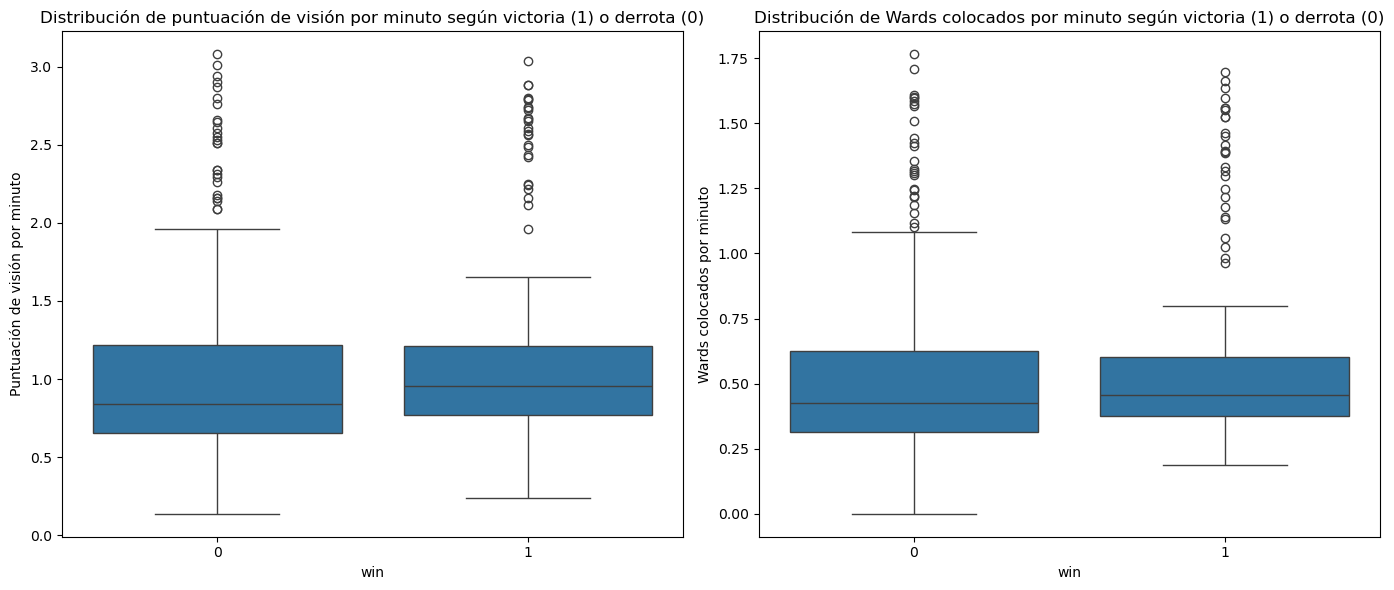

In [14]:
# Graficamos Boxplot de wins según vision score y wards por minutos  

plt.figure(figsize=(14,6))

# --- Subplot 1 ---
plt.subplot(1, 2, 1)
sns.boxplot(data=df_analytics, x='win', y='vs_per_min')
plt.ylabel('Puntuación de visión por minuto')
plt.title("Distribución de puntuación de visión por minuto según victoria (1) o derrota (0)")

# --- Subplot 2 ---
plt.subplot(1, 2, 2)
sns.boxplot(data=df_analytics, x='win', y='wards_per_min')
plt.ylabel('Wards colocados por minuto')
plt.title("Distribución de Wards colocados por minuto según victoria (1) o derrota (0)")

plt.tight_layout()
plt.show()

**Observación**

A simple vista no pareciera haber una diferencia significativa en ambas métricas respecto al target. Sin embargo, esto no es suficiente, por lo que es necesario un análisis estadístico para estar seguro de si existen una relevancia estadística y detectar si la puntuación de visión por minuto y la cantidad de wards por minutos realmente incide en la victoria.

Haré un test filtrando por tipo de partida con el fin de detectar si las variables cambian su comportamiento según si es solo Q o flex.

In [15]:
# 1. Test para conjunto de partidas FLEX
print ('Test para conjunto de partidas FLEX:')

# Test de hipótesis para corroborar si vs_per_min influye en las win cuando en games flex
stat_vs_per_min,p_valor_vs_per_min =  test_mann_whitney(
    df_analytics_flex,
    'vs_per_min','win',
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

# Test de hipótesis para corroborar si vs_per_min influye en las win cuando en games flex
stat_wards_per_min,p_valorwards_per_min =  test_mann_whitney(
    df_analytics_flex,
    'wards_per_min',
    'win', 
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

# 2. Test para conjunto de partidas Solo Q
print ('Test para conjunto de partidas Solo Q:')

# Test de hipótesis para corroborar si vs_per_min influye en las win cuando en games soloQ
stat_vs_per_min,p_valor_vs_per_min =  test_mann_whitney(
    df_analytics_soloq,
    'vs_per_min','win',
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.01,
    alternative='greater')

# Test de hipótesis para corroborar si vs_per_min influye en las win cuando en games soloQ
stat_wards_per_min,p_valorwards_per_min =  test_mann_whitney(
    df_analytics_soloq,
    'wards_per_min',
    'win', 
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

# 3. Test para todas las partidas.
print ('Test para todas las partidas:')

# Test de hipótesis para corroborar si vs_per_min influye en las win
stat_vs_per_min,p_valor_vs_per_min =  test_mann_whitney(
    df_analytics,
    'vs_per_min','win',
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

# Test de hipótesis para corroborar si vs_per_min influye en las win
stat_wards_per_min,p_valorwards_per_min =  test_mann_whitney(
    df_analytics,
    'wards_per_min',
    'win', 
    val_grupo1=1,
    val_grupo0=0,
    alpha = 0.05,
    alternative='greater')

Test para conjunto de partidas FLEX:
📊 TEST MANN-WHITNEY: 'vs_per_min' por 'win'
   H1 (Hipótesis Alternativa): Grupo '1' es MAYOR que Grupo '0'
   ❌ NO SIGNIFICATIVO (p >= 0.05)
   -> No se puede rechazar la Hipótesis Nula (H0).
   -> No hay evidencia suficiente para afirmar la relación planteada.
------------------------------------------------------------

📊 TEST MANN-WHITNEY: 'wards_per_min' por 'win'
   H1 (Hipótesis Alternativa): Grupo '1' es MAYOR que Grupo '0'
   ❌ NO SIGNIFICATIVO (p >= 0.05)
   -> No se puede rechazar la Hipótesis Nula (H0).
   -> No hay evidencia suficiente para afirmar la relación planteada.
------------------------------------------------------------

Test para conjunto de partidas Solo Q:
📊 TEST MANN-WHITNEY: 'vs_per_min' por 'win'
   H1 (Hipótesis Alternativa): Grupo '1' es MAYOR que Grupo '0'
   ✅ RESULTADO SIGNIFICATIVO (p < 0.01)
   -> Se rechaza la Hipótesis Nula (H0).
   -> Hay evidencia de que 'vs_per_min' es MAYOR en el grupo '1'.
----------------

### Observaciones sobre la Visión (Flex vs. SoloQ)

El análisis segmentado por tipo de cola reveló una disparidad crítica en el impacto de la visión:

1. **Flex:**
- Se rechaza la hipótesis de que la visión influye en la victoria ($p > 0.05$).
- El control de mapa no es la variable que diferencia las victorias de las derrotas en este entorno. Es necesario evaluar si las variables de combate directo (KDA, Daño, Oro) muestran la significancia estadística que la visión no tuvo.

2.  **Solo Q:** 
- Se encontró una **fuerte significancia estadística ($p < 0.01$)** para la *Calidad de Visión* (`vs_per_min`), pero no para la *Cantidad*.
- En el caos de SoloQ, la colocación inteligente de centinelas (calidad) ofrece una ventaja competitiva real, mientras que el "spam" de centinelas (cantidad) es irrelevante.

## Análisis del jugador:  BENCHMARK con liga actual y superior.

Basándonos en las estadísticas recopiladas por **ORACLES ELIXIR** y **LEAGUE OF GRAPHS**, podemos obtener difentes métricas de las partidas de todas las ligas de League of Legends, tanto de jugadores amateur como profesionales. Es en relación a dichas métricas que podemos comparar el rendimiento promedio de los jugadores de diferentes ligas con el propio.

** Para obtener la cantidad de wards por minuto utilicé el tiempo promedio de una partida de league of legends (30 minutos).

In [16]:
# Obtenemos el promedio wards_per_min por rol
wpm_flex = df_analytics_flex.groupby('role')['wards_per_min'].mean().round(2)
wpm_flex = pd.DataFrame(wpm_flex).rename(columns={'wards_per_min':'my_wpm_flex'})
wpm_soloQ = df_analytics_soloq.groupby('role')['wards_per_min'].mean().round(2)
wpm_soloQ = pd.DataFrame(wpm_soloQ).rename(columns={'wards_per_min':'my_wpm_soloQ'})
stats = pd.concat([wpm_soloQ,wpm_flex],axis=1)
stats = pd.DataFrame(stats)


# Datos de promedio wards_per_min por rol sacados de League of Graphs (Diamante y Master)
total_wards_diamond = {
    'TOP': 9.3,
    'JUNGLE': 5.5,
    'MIDDLE': 10,
    'BOTTOM': 9.5,
    'UTILITY': 29.5
}

total_wards_master = {
    'TOP': 8.8,
    'JUNGLE': 5.2,
    'MIDDLE': 9.4,
    'BOTTOM': 9.1,
    'UTILITY': 29.5
}
# Dataframe de mean_wards_master diamante
benchmark_diamond = pd.DataFrame.from_dict(
    total_wards_diamond, 
    orient='index', 
    columns=['mean_wards_diamond']
)

# Dataframe de mean_wards_master master
benchmark_master = pd.DataFrame.from_dict(
    total_wards_master, 
    orient='index', 
    columns=['mean_wards_master']
)

# Obtiene el "Total" de "Wards por Minuto" estimado
STANDARD_DURATION = 30 
benchmark_diamond['wpm_diamond'] = (benchmark_diamond['mean_wards_diamond'] / STANDARD_DURATION).round(2)
benchmark_master['wpm_master'] = (benchmark_master['mean_wards_master'] / STANDARD_DURATION).round(2)

# Une los set de datos (mi data vs data diamante vs data master).
df_benchmark = pd.concat([benchmark_diamond,benchmark_master,stats],axis=1)
df_benchmark = df_benchmark.drop(columns= ['mean_wards_diamond','mean_wards_master'])
df_benchmark

,wpm_diamond,wpm_master,my_wpm_soloQ,my_wpm_flex
TOP,0.31,0.29,0.40,0.48
JUNGLE,0.18,0.17,0.29,0.35
MIDDLE,0.33,0.31,0.56,NaN
BOTTOM,0.32,0.30,0.45,0.43
UTILITY,0.98,0.98,0.78,1.31


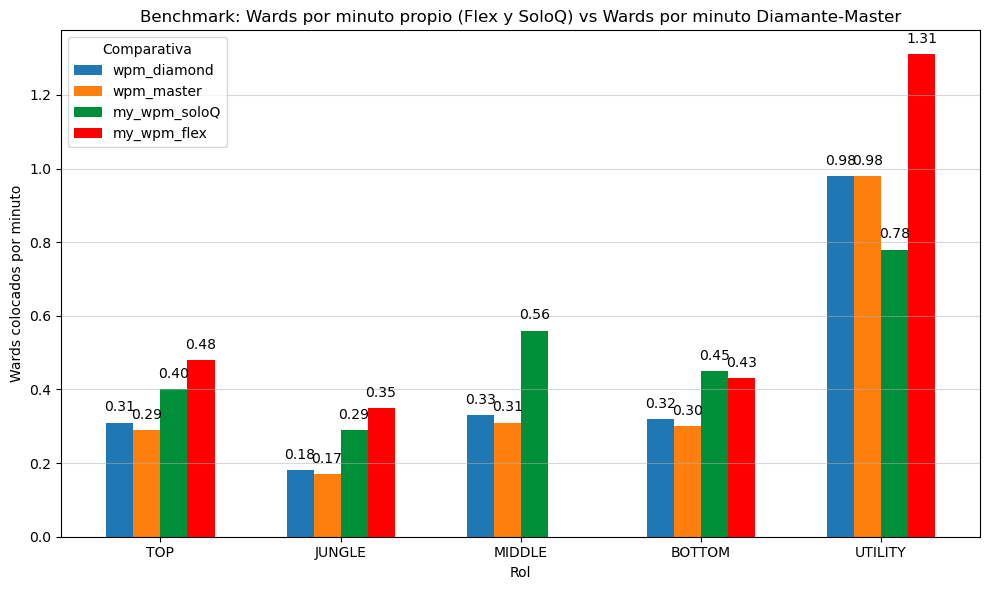

In [17]:
# Graficamos el benchmark

ax = df_benchmark.plot(
    kind='bar',
    figsize=(10, 6),
    width=0.6,   
    color=['#1f77b4', '#ff7f0e', '#008f39', '#ff0000']
)

plt.title('Benchmark: Wards por minuto propio (Flex y SoloQ) vs Wards por minuto Diamante-Master')
plt.ylabel('Wards colocados por minuto')
plt.xlabel('Rol')
plt.grid(axis='y', alpha=0.5)
plt.xticks(rotation=0)
plt.legend(title='Comparativa')

# Etiquetas mejoradas
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            xytext=(0, 6),  
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()

**Observación**

- **Flex:** Se observa una ineficiencia de la visión. El volumen de centinelas colocados supera el estándar de liga actual (diamante)y de la siguiente (master) en casi todos los roles, pero no genera impacto estadístico en el resultado de las partidas. Se está invirtiendo oro y tiempo en visión poco útil. La estrategia óptima es reducir el volumen de compra para liberar recursos hacia variables con mayor correlación potencial (Daño/Oro).

- **Solo Q (Top/Jg/Bot)**: Se mantiene el patrón de exceso vs el elo actual y el superior, pero  existe evidencia estadística que mejora la eficiencia (vision_score) respecto a las partidas Flex. Se recomienda reducir cantidad y priorizar calidad.

- **Solo Q (Soporte):** Es la única excepción crítica. Tu volumen (0.78) está por debajo del estándar de Diamante (0.98). Al ser la visión estadísticamente significativa en SoloQ, este déficit debe corregirse. Acción: Aumentar frecuencia de wardeo exclusivamente cuando juegues Soporte en SoloQ.

## Análisis del jugador:  W/R por rol y por campeón (análisis champeon pool)

Revisamos la cantidad de juegos ganados por rol y por campeón con el fin de obtener información de cuáles son mis mejores roles y campeones en relación a la cantidad de partridas ganadas (análisis general, en partidas Solo Q y Flexible). De esta forma, analizar si mis roles y champs mains están siendo efectivos.

In [18]:
# Agrupamos por rol y calculamos suma (wins) y cuenta (total de partidas en el rol)
wr_per_rol_general = df_analytics.groupby('role')['win'].agg(['sum', 'count'])
wr_per_rol_flex = df_analytics_flex.groupby('role')['win'].agg(['sum', 'count'])
wr_per_rol_soloq = df_analytics_soloq.groupby('role')['win'].agg(['sum', 'count'])

# Renombramos columnas para mayor legibilidad
wr_per_rol_general = wr_per_rol_general.rename(columns={'sum':'Victorias','count':'Total_Partidas'})
wr_per_rol_flex = wr_per_rol_flex.rename(columns={'sum':'Victorias','count':'Total_Partidas'})
wr_per_rol_soloq = wr_per_rol_soloq.rename(columns={'sum':'Victorias','count':'Total_Partidas'})

# Creamos columna del win rate por rol
wr_per_rol_general['WR_per_role_general'] = (wr_per_rol_general['Victorias'] / wr_per_rol_general['Total_Partidas']).round(2)
wr_per_rol_flex['WR_per_role_flex'] = (wr_per_rol_flex['Victorias'] / wr_per_rol_flex['Total_Partidas']).round(2)
wr_per_rol_soloq['WR_per_role_soloq'] = (wr_per_rol_soloq['Victorias'] / wr_per_rol_soloq['Total_Partidas']).round(2)

'''
# Filtramos por cantidad de partidas de cada rol
wr_per_rol_general = wr_per_rol_general[wr_per_rol_general['Total_Partidas'] > 10]
wr_per_rol_flex = wr_per_rol_flex[wr_per_rol_flex['Total_Partidas'] > 10]
wr_per_rol_soloq = wr_per_rol_soloq[wr_per_rol_soloq['Total_Partidas'] > 10]
'''

"\n# Filtramos por cantidad de partidas de cada rol\nwr_per_rol_general = wr_per_rol_general[wr_per_rol_general['Total_Partidas'] > 10]\nwr_per_rol_flex = wr_per_rol_flex[wr_per_rol_flex['Total_Partidas'] > 10]\nwr_per_rol_soloq = wr_per_rol_soloq[wr_per_rol_soloq['Total_Partidas'] > 10]\n"

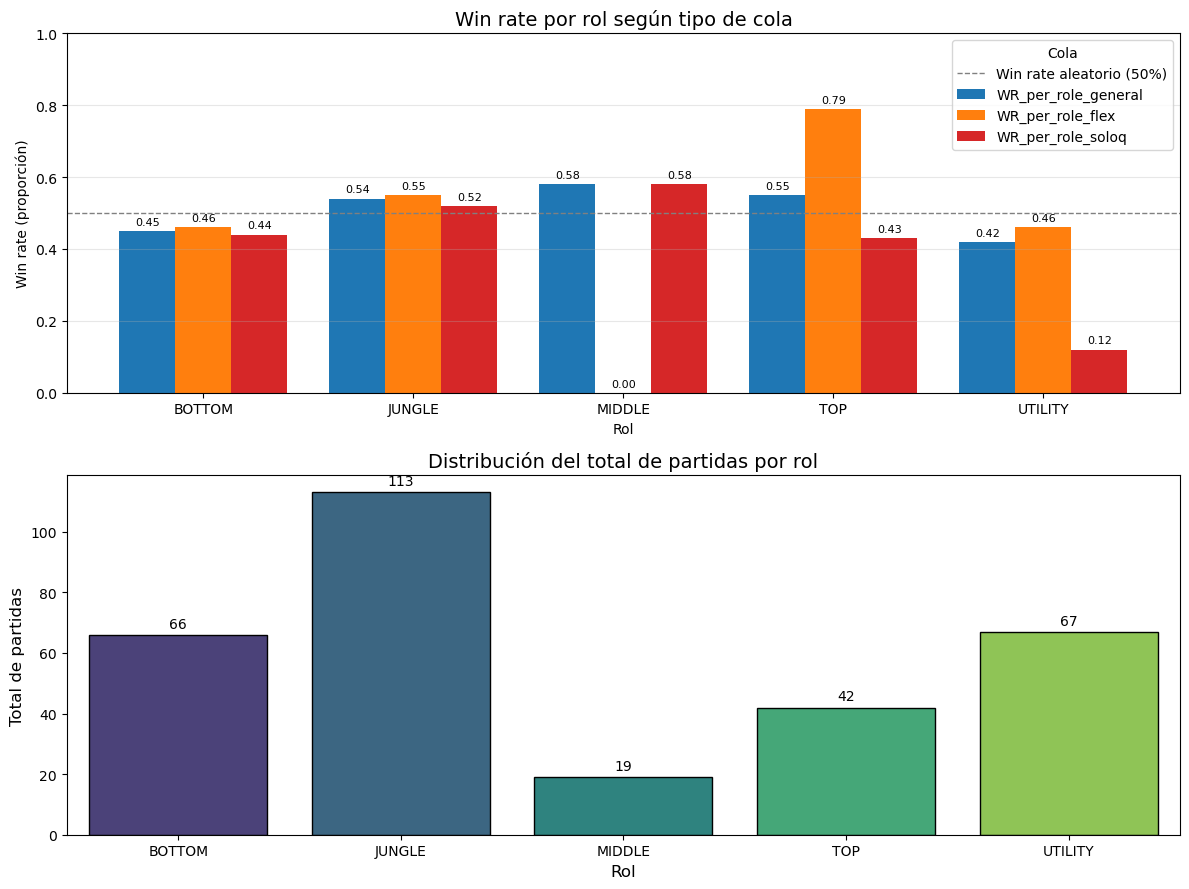

In [19]:
wr_analytics = pd.concat([
    wr_per_rol_general['WR_per_role_general'],
    wr_per_rol_flex['WR_per_role_flex'],
    wr_per_rol_soloq['WR_per_role_soloq']],
    axis = 1)
    

fig, ax = plt.subplots(2, 1, figsize=(12, 9))

# Gráfico win ratio por rol por tipo de cola
wr_analytics.plot(
    kind='bar',
    width=0.8,
    color=['#1f77b4', '#ff7f0e', '#d62728'],
    ax=ax[0] # Directo al primer eje
)

# Formato y Etiquetas para ax[0]
ax[0].set_ylim(0.0, 1.0) # Corrección Crítica
ax[0].axhline(0.5, color='gray', linestyle='--', linewidth=1, label='Win rate aleatorio (50%)')
ax[0].set_title('Win rate por rol según tipo de cola', fontsize=14)
ax[0].set_ylabel('Win rate (proporción)')
ax[0].set_xlabel('Rol')
ax[0].tick_params(axis='x', rotation=0) 
ax[0].grid(axis='y', alpha=0.3)
ax[0].legend(title='Cola')

# Anotaciones sobre barras para ax[0]
for p in ax[0].patches:
    height = p.get_height()
    ax[0].annotate(
        f"{height:.2f}", 
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom',
        xytext=(0, 3), 
        textcoords='offset points', 
        fontsize=8
    )

# Gráfico TOTAL GAMES DISTRIBUTION 
sns.barplot(
    data=wr_per_rol_general.reset_index(), 
    x=wr_per_rol_general.index.name,
    y="Total_Partidas",
    palette="viridis",
    edgecolor="black",
    ax=ax[1] # Directo al segundo eje
)

# Formato y Etiquetas para ax[1]
ax[1].set_title("Distribución del total de partidas por rol", fontsize=14)
ax[1].set_xlabel("Rol", fontsize=12)
ax[1].set_ylabel("Total de partidas", fontsize=12)
ax[1].tick_params(axis='x', rotation=0) 

# Anotaciones sobre barras para ax[1]
for bar in ax[1].patches:
    height = bar.get_height()
    ax[1].annotate(
        f"{height:.0f}", 
        (bar.get_x() + bar.get_width() / 2, height),
        ha='center',
        va='bottom',
        fontsize=10,
        xytext=(0, 3),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()

In [20]:
# Creamos una columna para ver el win ratio de cada campeón según el rol que fui
champ_stats_flex = df_analytics_flex.groupby(['champion', 'role'])['win'].agg(['sum', 'count'])
champ_stats_soloq = df_analytics_soloq.groupby(['champion', 'role'])['win'].agg(['sum', 'count'])
champ_stats_general = df_analytics.groupby(['champion', 'role'])['win'].agg(['sum', 'count'])

# 2. Renombrar columnas para claridad
champ_stats_flex.columns = ['Victorias', 'Total_Partidas']
champ_stats_soloq.columns = ['Victorias', 'Total_Partidas']
champ_stats_general.columns = ['Victorias', 'Total_Partidas']

# 3. FILTRO DE RELEVANCIA (Crucial)
# Eliminamos combinaciones raras (ej: jugaste 1 vez Yasuo soporte).
# Filtramos campeones con menos de 5 partidas en ese rol específico.
champ_stats_general = champ_stats_general[champ_stats_general['Total_Partidas'] >= 5] # 5 Revisar campeones con buena proyección
champ_stats_flex = champ_stats_flex[champ_stats_flex['Total_Partidas'] >= 5]
champ_stats_soloq = champ_stats_soloq[champ_stats_soloq['Total_Partidas'] >= 5] 

# 4. Calcular Win Rate
champ_stats_flex['Win_Rate_flex'] = (champ_stats_flex['Victorias'] / champ_stats_flex['Total_Partidas']).round(2)
champ_stats_soloq['Win_Rate_soloq'] = (champ_stats_soloq['Victorias'] / champ_stats_soloq['Total_Partidas']).round(2)
champ_stats_general['Win_Rate_general'] = (champ_stats_general['Victorias'] / champ_stats_general['Total_Partidas']).round(2)

# 5. Ordenar para el Análisis
# Ordenamos por Total para ver tus "Mains" primero.
champ_stats_flex = champ_stats_flex.sort_values(['Total_Partidas'], ascending=[False])
champ_stats_soloq = champ_stats_soloq.sort_values(['Total_Partidas'], ascending=[False])
champ_stats_general = champ_stats_general.sort_values(['Total_Partidas'], ascending=[False])

# Visualización
print("--- Stats generales ---")
print(champ_stats_general)
print("-"*60)
print("\n")
print("--- Stats Flex ---")
print(champ_stats_flex)
print("-"*60)
print("\n")
print("--- Stats Solo Q ---")
print(champ_stats_soloq)

--- Stats generales ---
                    Victorias  Total_Partidas  Win_Rate_general
champion   role                                                
Sejuani    JUNGLE          24              38              0.63
Trundle    JUNGLE          14              31              0.45
JarvanIV   JUNGLE          19              30              0.63
Thresh     UTILITY         14              30              0.47
Ezreal     BOTTOM          11              21              0.52
Vayne      BOTTOM           9              18              0.50
Trundle    TOP              8              16              0.50
Blitzcrank UTILITY          5              11              0.45
Braum      UTILITY          4              10              0.40
Leblanc    MIDDLE           7               9              0.78
Smolder    BOTTOM           2               7              0.29
Leona      UTILITY          3               6              0.50
Malphite   TOP              4               6              0.67
Illaoi     TOP  

**Observación W/R de rol** y **W/R de campeones (FLEX)**

- **Rol Jungla**: Jungla ha sido el rol principal (114 games) y el win ratio ronda entre 52% (Solo Q) y 55% (flex), un rendimiento decente.
  
- **Champeon pool jungla:** 
   - **Trundle**: En SoloQ tienen un w/r del 62%, mientras que en Flex es del 27%, lo que baja ratio de victorias general a un 42%. Es decir, reduce significativamente el win ratio de victorias del rol. Que este campeón tenga mejor rendimiento en Solo Q que en Flex puede deberse a que tengo un peor rendimiento en jugadas coordinadas o peleas de equipo.
 
   - **Sejuani**: En Flex tiene un w/r de 63% en 38 partidas (más del doble de partidas que con Trundle en SoloQ), lo que es un pick de alto valor para Flexible. Puede deberse a un mejor rendimiento en peleas de equipo y jugadas coordinadas.
 
   -  **Jarvan**: En Flex tiene un w/r de 63% en 30 partidas, por lo que, al igual que Sejuani, es un pick de alto valor para subir de elo en Flex.
  
- **Accionable para el rol de jungla:** Limitar el uso de Trundle a SoloQ y eliminarlo de Flex (no tiene buen rendimiento) y mantener los picks de  ***Jarvan*** y ***Sejuani*** en Flexible.
---

- **Rol TOP**: Es el rol con mejor win rate junto con jungla. y el win ratio ronda entre 52% (Solo Q) y 55% (flex), un rendimiento decente.Sin embargo, tiene un bajo registro de partidas por lo que se requiere más base estadística para obtener métricas más ajustadas a la realidad.

- **Champeon pool TOP:**
   - **Trundle**: Este pick es una ruleta, es completamente azar ganar o perder si lo juegas en top.
     
   - **Malphite e Illaoi**: Solo de puede detectar que campeones como Malphite (67% w/r en 6 jeugos) o Illaoi (100% de w/r en 5 juegos) tienen una buena proyección para Flexible.
     
- **Accionable para el rol de TOP:** Deja de jugar top en SoloQ (especialmente Trundle). Prioriza Malphite o Illaoi e igual puedes testear como funcionan en SoloQ.

---

- **Rol Soporte:** Es el rol con peor win ratio general junto con ADC (42% w/r), lo que indica que es el rol con peor impacto en partidas flexibles.

  - **Champeon pool Soporte:**

  - **Thresh**: Dentro de los malos soportes utilizados es "el menos malo", pero tiene un w/r deficiente de 47%). Es mucho mejor que el ratio de victorias de Braum y Blitzcrank, pero aún asi no alcanza ni el 50%. 
  
- **Accionable para el rol de Soporte:** Deja de jugar soporte en Flex, tu aporte es inutil, mantén los esfuerzos en otros roles y, solo si sales por comodín, usa Thresh. Podrías intentar prácticar en SoloQ y evaluar los resultados, pero no es un rol que aporte para Flex.

---
 
- **Rol ADC:** Es el rol con uno de los peores win rate general (w/r 45%).

  - **Champeon pool ADC:**
    
  - **Ezreal**: A pesar de tener mal win ratio en general en el rol, con Ezreal tienes un buen rendimiento de ADC (56% w/r), si vas a jugar ADC, juega Ezreal.
    
  - **Vayne**: Jugar este campeon es dejar la partida al azar. No es recomendable usarlo, solo sutuacionalmente.

- **Accionable para el rol de ADC:** Solo juega Ezreal. No uses ninguna otra opcion. En caso de existir muchos tanques, rota a Vayne, que si bien es un pick arriesgado, es bueno contra tankes, mientras que Ezreal no es efectivo contra ellos.
---

- **Rol MID:** No hay evidencia suficiente para evaluar este rol. Si bien tiene un 58% de win rate, son muy pocas partidas. Aún así, LeBlanc puede ser un campeón con buena proyección para MID dado que tiene 78% w/r en 9 partidas.

- **Accionable para el rol de MID:** Puede seguir usando a Leblanc en SoloQ y evaluar las métricas que obtengas.

---
**KPI - Win Rate:**

- Mantener un Win Rate del "Champion Pool" de cada rol > 55%.

- Cualquier campeón con >20 partidas y <48% WR se considera "Incompatible" y se elimina de la rotación competitiva.


## Análisis comportamiento del sistema: Elasticidad y "Loss Q" (corrección de MMR)

Más allá del rendimiento individual por campeón, es crítico analizar el comportamiento del algoritmo de emparejamiento (Matchmaking).

El Objetivo: Investigar estadísticamente la existencia de patrones de corrección forzada (coloquialmente conocidos como "Losers Queue"). Se busca determinar si el sistema impone una resistencia artificial tras rachas de victorias para forzar una regresión al 50% de Win Rate.

**¿El estancamiento en la liga se debe a un límite de habilidad personal o a un techo artificial algorítmico que penaliza las rachas positivas excesivas?**

### Elasticidad Partidas Flex

In [21]:
# 1. Identificador de rachas y racha actual por partida.
# Creamos un agrupador de rachas y asignamos un identificador (comienza en 1). 
# Si el resultado actual es distinto al anterior, empieza nueva racha, por lo tanto, un nuevo identificador.
df_analytics_flex['streak_group'] = (df_analytics_flex['win'] != df_analytics_flex['win'].shift(1)).cumsum()
df_analytics_flex['streak_counter'] = df_analytics_flex.groupby('streak_group').cumcount() + 1


# Obtenemos la racha actual y determinamos si es racha de derrotas o de victorias
# Multiplica por 1 o -1. Cuando se gana se deja como racha de victorias (1,2,3...), cuando no, como derrotas (-1,-2,-3...). 
df_analytics_flex['racha_actual'] = np.where(
    df_analytics_flex['win'] == 1, 
    df_analytics_flex['streak_counter'],      # Caso Win: 3
    df_analytics_flex['streak_counter'] * -1  # Caso Loss: -3
)

# Hacemos lo mismo para SoloQ
# Identificador de racha
df_analytics_soloq['streak_group'] = (df_analytics_soloq['win'] != df_analytics_soloq['win'].shift(1)).cumsum()
df_analytics_soloq['streak_counter'] = df_analytics_soloq.groupby('streak_group').cumcount() + 1

# Racha actual
df_analytics_soloq['racha_actual'] = np.where(
    df_analytics_soloq['win'] == 1, 
    df_analytics_soloq['streak_counter'],      # Caso Win: 3
    df_analytics_soloq['streak_counter'] * -1  # Caso Loss: -3
)

# Creamos la columna racha previa para tener la racha sin considerar la partida actual
# Crear "racha previa" da contexto sin reiterar información de victoria.
df_analytics_soloq['racha_previa'] = df_analytics_soloq['racha_actual'].shift(1).fillna(0).astype(int)
df_analytics_flex['racha_previa'] = df_analytics_flex['racha_actual'].shift(1).fillna(0).astype(int)
 
# 2. Predecir el FUTURO (Target Leakage intencional para análisis)
# Queremos saber: "Dada mi racha actual, ¿gané la SIGUIENTE?"
df_analytics_flex['next_game_win'] = df_analytics_flex['win'].shift(-1)
df_analytics_soloq['next_game_win'] = df_analytics_soloq['win'].shift(-1)

# Para graficar
# Agrupamos por la racha actual y obtenemos el promedio de ganar la siguiente partida y la frecuencia de las racha. 
streak_stats_flex = df_analytics_flex.groupby('racha_actual')['next_game_win'].agg(['mean', 'count'])
streak_stats_flex = streak_stats_flex[streak_stats_flex['count'] >= 5].round(2) # Mínimo 5 casos para que sea estadísticamente válido
                 
streak_stats_soloq = df_analytics_soloq.groupby('racha_actual')['next_game_win'].agg(['mean', 'count'])
streak_stats_soloq = streak_stats_soloq[streak_stats_soloq['count'] >= 5].round(2) 

--- Probabilidad de Ganar la SIGUIENTE partida según tu Racha Actual ---
              mean  count
racha_actual             
-3            0.64     11
-2            0.59     27
-1            0.49     53
 1            0.49     53
 2            0.58     26
 3            0.40     15
 4            0.50      6


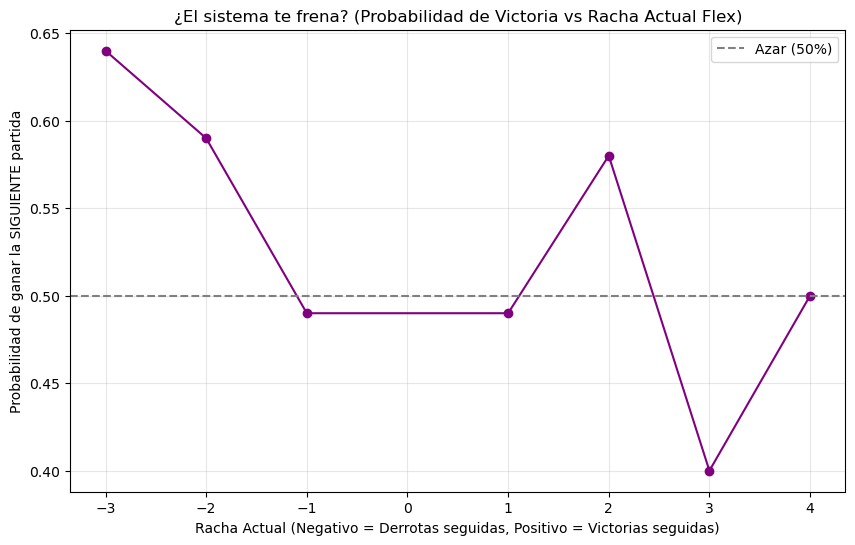

In [22]:
# Graficamos los datos obtenidos

print("--- Probabilidad de Ganar la SIGUIENTE partida según tu Racha Actual ---")
print(streak_stats_flex)

plt.figure(figsize=(10, 6))
plt.plot(streak_stats_flex.index, streak_stats_flex['mean'], marker='o', linestyle='-', color='purple')
plt.axhline(0.5, color='gray', linestyle='--', label='Azar (50%)')
plt.title('¿El sistema te frena? (Probabilidad de Victoria vs Racha Actual Flex)')
plt.xlabel('Racha Actual (Negativo = Derrotas seguidas, Positivo = Victorias seguidas)')
plt.ylabel('Probabilidad de ganar la SIGUIENTE partida')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### Elasticidad Partidas Solo Q

--- Probabilidad de Ganar la SIGUIENTE partida según tu Racha Actual ---
              mean  count
racha_actual             
-3            0.50      8
-2            0.43     14
-1            0.48     27
 1            0.41     27
 2            0.64     11
 3            0.43      7


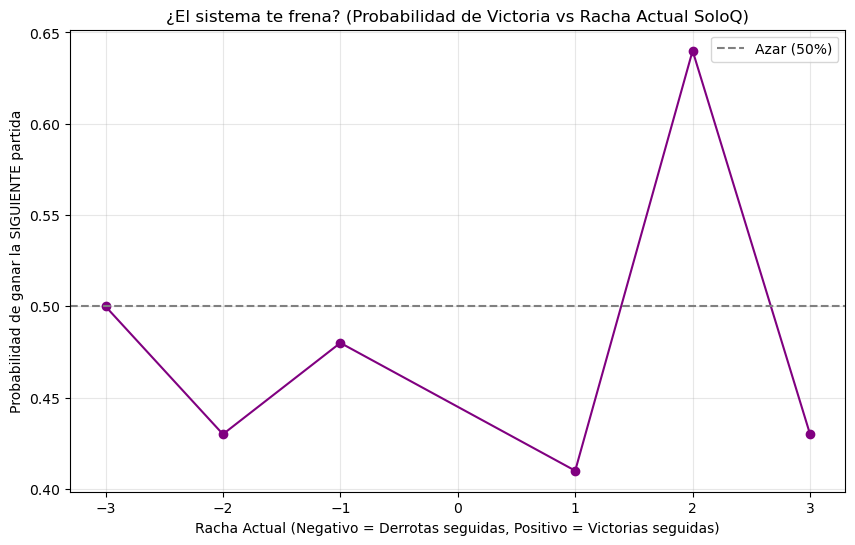

In [23]:
# Graficamos los datos obtenidos

print("--- Probabilidad de Ganar la SIGUIENTE partida según tu Racha Actual ---")
print(streak_stats_soloq)

plt.figure(figsize=(10, 6))
plt.plot(streak_stats_soloq.index, streak_stats_soloq['mean'], marker='o', linestyle='-', color='purple')
plt.axhline(0.5, color='gray', linestyle='--', label='Azar (50%)')
plt.title('¿El sistema te frena? (Probabilidad de Victoria vs Racha Actual SoloQ)')
plt.xlabel('Racha Actual (Negativo = Derrotas seguidas, Positivo = Victorias seguidas)')
plt.ylabel('Probabilidad de ganar la SIGUIENTE partida')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Observaciónes**
Logramos detectar claramente una tendencia que, luego de una racha de 3 victorias -tanto en Flex como Solo Q-, las probabilidades de ganar una cuarta partida son de máxmimo un 43%. Es decir, el matchmaking intenta corregir el mmr en racha de victorias. De este modo, evita que subas por factores aleatorios y premia a quien tiene las habilidades necesarias para seguir subiendo de liga.

Sin embargo, mientras que en Flex existe una especie de "salvavidas" luego de una racha de derrotas, en Solo Q no es el caso. La probabilidad de ganar en Flex una partida luego de una racha de 3 derrotas es del 64%; en solo Q es de un 50% (puro azar). En cola Flex existe una salvación, Solo Q es una caida al vacío. 

Esta situación da una respuesta más clara:
- En Solo Q: **PARA MÍ** la probabilidad de subir es bastante más baja que la probabilidad de bajar.
- En Flex: El sistema actúa sobre mí como un estabilizador, haciendo improbable tanto el ascenso rápido como el descenso brusco.

Por otro lado, es relevante preguntarse: **¿Es el matchmaking el que crea una situación de baja probabilidad de victoria luego de una racha de 3 victorias o es mi rendimiento personal que empeora en una racha de +3 victorias?**


### Matchmaking malévolo o rendimiento inestable luego de +3 victorias.

Al no tener una idea preestablecida de que existe un patron de "la siguiente partida luergo de 3 victorias es un techo de mmr el cual debo romper para seguir ganando", la única manera de poder verificar si pierdo por tilt o por matchmaking es revisar mi rendimiento en juegos que son "bajo presión" (racha +3 victorias) y de juegos que no lo son. De esta manera, si son derrotas aplastantes tiene más sentido que las derrotas en la 4ta partida sea por variables de entorno (emparejamiento) que por tilteo o conocimiento de este suceso, dado que no tenía como saber que en ese momento era una partida de "MMR_check".

In [24]:
# 1. Identificar las "Partidas de Presión" (Cuando vienes de racha +3)
# Usamos la lógica de rachas anterior (asegúrate de tener 'current_streak' calculado)
df_analytics_flex['is_MMR_check'] = df_analytics_flex['racha_actual'].shift(1) == 3

# 2. Seleccionar métricas de rendimiento PERSONAL (Que dependen solo de ti)
# No uses 'win' ni 'dragons', usa cosas que controlas tú.
metrics = ['min15_cs_diff', 'min15_gold_diff', 'min15_xp_diff', 'vs_per_min','KDA']

# 3. Comparar Promedios
pressure_analysis_flex = df_analytics_flex.groupby('is_MMR_check')[metrics].mean()

print("--- Rendimiento Flex: Normal vs Presión (Racha +3) ---")
pressure_analysis_flex

--- Rendimiento Flex: Normal vs Presión (Racha +3) ---


,min15_cs_diff,min15_gold_diff,min15_xp_diff,vs_per_min,KDA
is_MMR_check,,,,,
False,-8.951872,-308.096257,-316.106952,1.299632,5.123102
True,-9.133333,-680.066667,-581.000000,1.453570,2.880667


In [25]:
# 1. Identificar las "Partidas de Presión" (Cuando vienes de racha +3)
# Usamos la lógica de rachas anterior (asegúrate de tener 'current_streak' calculado)
df_analytics_soloq['is_MMR_check'] = df_analytics_soloq['racha_actual'].shift(1) == 3

# 2. Seleccionar métricas de rendimiento PERSONAL (Que dependen solo de ti)
# No uses 'win' ni 'dragons', usa cosas que controlas tú.
metrics = ['min15_cs_diff', 'min15_gold_diff', 'min15_xp_diff', 'vs_per_min','KDA']

# 3. Comparar Promedios
pressure_analysis_soloq = df_analytics_soloq.groupby('is_MMR_check')[metrics].mean()

print("--- Rendimiento Solo Q: Normal vs Presión (Racha +3) ---")
pressure_analysis_soloq

--- Rendimiento Solo Q: Normal vs Presión (Racha +3) ---


,min15_cs_diff,min15_gold_diff,min15_xp_diff,vs_per_min,KDA
is_MMR_check,,,,,
False,-6.561224,-378.122449,-389.785714,0.84015,3.133878
True,-14.000000,-679.714286,-815.285714,0.67349,1.584286


**Observaciones**

Tanto en solo Q como en Flex podemos ver una diferencia sustancial entre los juegos "bajo presión" y los que no. En esa 4ta partida, tu rival de línea es mecánicamente superior, obtiene más (XP), farmea mejor (Gold). 
A pesar de que mi vision score no empeora tanto, mi KDA final si. Un pero rendimiento general.

Sin embargo, **al desconocer este patrón, no es que esté jugando "peor" por miedo a no ganar un 4to game en racha de victorias**; es que el rival es mejor que yo. **El sistema elevó mi MMR tras la racha de victorias y me enfrenté a un oponente que no le pude ganar**.

**Estrategia:** En la 4ta partida jugar un pick más seguro/defensivo (ej: Sejuani, Malphite) y asume que vas a perder línea. Enfócate exclusivamente en no fedear y absorber presión para que el equipo te carree. Tu objetivo en esa partida no es ganar la línea, es sobrevivir al rival superior.

In [26]:

# 1. Quitamos la columna racha_actual
# Dejar esa columna es información repetida: "Estoy en racha de 2 porque gané la partida anterior y  esta", es repetir que gané la partida 2 veces.
df_analytics_flex = df_analytics_flex.drop(columns = ['racha_actual'])
df_analytics_soloq = df_analytics_soloq.drop(columns = ['racha_actual'])

# 2. Guardamos la versión final del DataFrame de analitica (incluyendo las rachas de cada tipo de juego)
# Exportamos toda la información para futuros análisis y modelamiento
df_analytics_flex = df_analytics_flex.drop(columns = ['next_game_win','streak_group','streak_counter']) # Quitamos columnas técnicas
df_analytics_soloq = df_analytics_soloq.drop(columns = ['next_game_win','streak_group','streak_counter'])
df_data_process = pd.concat([df_analytics_soloq,df_analytics_flex],ignore_index=True) # Unimos ambos dataframes
df_data_process['is_MMR_check'] = df_data_process['is_MMR_check'].astype(int) # Binarizamos la columna


# 3. Convertimos la columna categórica 'role' y 'queue_id' en columnas binarias (dummies)
df_data_process = pd.get_dummies(
    df_data_process, 
    columns=['role'], 
    drop_first=True, 
    dtype=int)

df_data_process['is_flex'] = (df_data_process['queue_id'] == 440).astype(int)
df_data_process = df_data_process.drop(columns = ['queue_id'])

# Verificamos que la binarización esté correcta
num_mmr_check_flex = df_analytics_flex[df_analytics_flex['is_MMR_check']==1].shape[0]
num_mmr_check_soloq = df_analytics_soloq[df_analytics_soloq['is_MMR_check']==1].shape[0]
num_mmr_check_process = df_data_process[df_data_process['is_MMR_check']==1].shape[0]
print(f'Existen {num_mmr_check_flex + num_mmr_check_soloq} partidas de chequeo de MMR en flex y solo Q')

if num_mmr_check_process == (num_mmr_check_flex + num_mmr_check_soloq):
    print(f"En el dataframe exportado existen {num_mmr_check_process} partidas de chequeo de MMR. Todo está correcto")
    # Exportamos la data procesada
    df_data_process.to_csv("data_procesada.csv", index=False)
    print("✅ Dataset guardado como 'data_procesada.csv'")
    print("-"*10)
else:
    print(f"En el dataframe exportado existen {num_mmr_check_process} partidas de chequeo de MMR. Algo salió mal, hay una diferencia entre los DF")
    print(f"✖️ Revisa el dataframe generado")
    print("-"*10)

df_analytics = df_data_process.copy() # Guardamos el data frame para las correlaciones



Existen 22 partidas de chequeo de MMR en flex y solo Q
En el dataframe exportado existen 22 partidas de chequeo de MMR. Todo está correcto
✅ Dataset guardado como 'data_procesada.csv'
----------


---

## Análisis de correlaciones

Analizamos las correlaciones entre las variables. De esta manera detectamos que correlaciones son las más fuertes y entender cuáles son las que más correlacionan con el target (win). 

Separamos los análisis entre partidas Flex, Solo Q y ambas, para ver cómo se comportan en cada tipo de juego y, además, en su conjunto global.

** Posteriormente, este análisis de correlaciones servirá para hacer selección de variables y optimizar el modelamiento.

### Análisis de correlaciones: FLEX

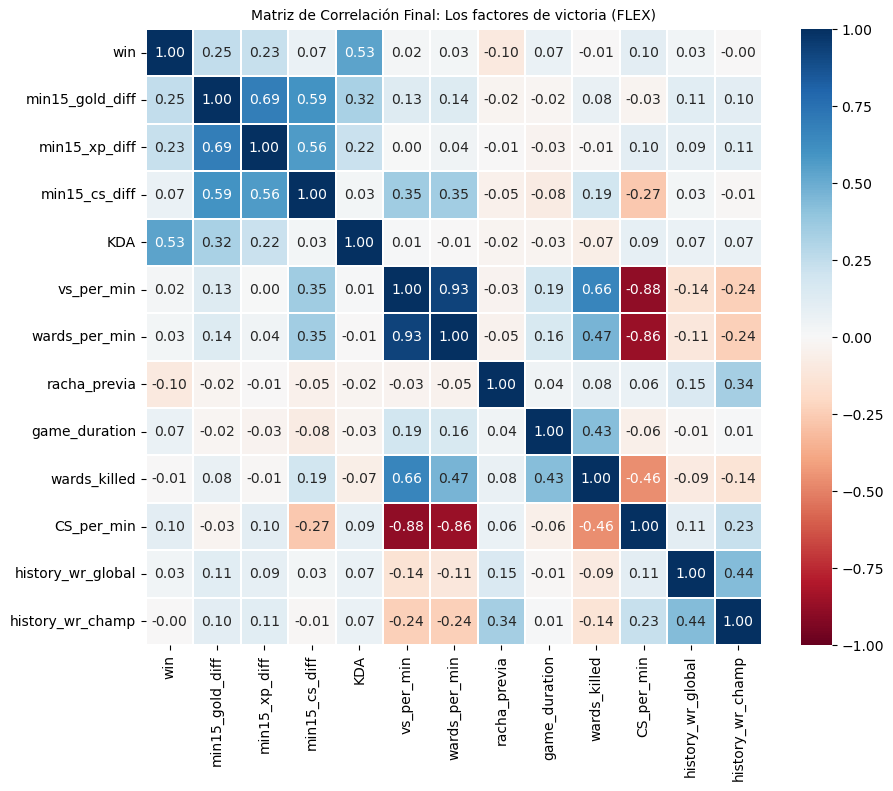

------------------------------------------------------------------------------------------------------------------------
--- 🏆 RANKING DE IMPACTO EN LA VICTORIA (FLEX) ---
KDA                  0.533305
min15_gold_diff      0.249092
min15_xp_diff        0.234220
CS_per_min           0.102517
racha_previa         0.095956
min15_cs_diff        0.065728
game_duration        0.065456
history_wr_global    0.034000
wards_per_min        0.026513
vs_per_min           0.021716
wards_killed         0.007551
history_wr_champ     0.004954
Name: win, dtype: float64

--- ¿Relación directa o inversa? (Ayuda + / - Perjudica) ---
KDA                  0.533305
min15_gold_diff      0.249092
min15_xp_diff        0.234220
CS_per_min           0.102517
min15_cs_diff        0.065728
game_duration        0.065456
history_wr_global    0.034000
wards_per_min        0.026513
vs_per_min           0.021716
history_wr_champ    -0.004954
wards_killed        -0.007551
racha_previa        -0.095956
Name: win, dtype: fl

In [29]:
# 1. SELECCIÓN QUIRÚRGICA DE VARIABLES
# En lugar de borrar lo que sobra, elegimos a los titulares del equipo.
cols_to_analyze = [
    'win',
    'min15_gold_diff',      # ¿Obtuve más oro que mi rival? 
    'min15_xp_diff',        # ¿Obtuve ventaja de nivel de mi rival?
    'min15_cs_diff',        # ¿Farmeaste mejor que tu rival?
    'KDA',                  # Rendimiento en combate
    'vs_per_min',           # Calidad de visión 
    'wards_per_min',        # Cantidad de visión
    'racha_previa',         # Racha de vicotoria/derrotas hasta el momento
    'game_duration',        # Duración de la partida
    'wards_killed',         # visión destruida
    'CS_per_min',           # Farm por min
    'history_wr_global',    # Win ratio hasta el momento
    'history_wr_champ'      # Win ratio del champ hasta el momento
    
]

# Filtro de seguridad: Solo usamos las columnas que existen en tu DF final
# (Usamos el DF unido para ver el panorama general)
cols_existing = [c for c in cols_to_analyze if c in df_analytics.columns]

# 2. CÁLCULO
# No necesitas escalar los datos para la correlación de Pearson.
corr_matrix = df_analytics_flex[cols_existing].corr()

# 3. VISUALIZACIÓN (HEATMAP PROFESIONAL)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,             # Muestra los números
    cmap='RdBu',            # Rojo=Te hace perder, Azul=Te hace ganar
    vmin=-1, vmax=1,        # Fijamos la escala entre -1 y 1
    fmt=".2f",              # 2 decimales
    linewidths=0.3,
    square=True
)
plt.title('Matriz de Correlación Final: Los factores de victoria (FLEX)', fontsize=10)
plt.show()

# 4. EL RANKING DE LA VERDAD (Dato Duro)

print("-"*120)
print("--- 🏆 RANKING DE IMPACTO EN LA VICTORIA (FLEX) ---")
# Ordenamos por fuerza absoluta (abs) para ver qué pesa más
ranking = corr_matrix['win'].drop('win').abs().sort_values(ascending=False)
print(ranking)

print("\n--- ¿Relación directa o inversa? (Ayuda + / - Perjudica) ---")
print(corr_matrix['win'].drop('win').sort_values(ascending=False))

**Observaciones FLEX**

Las variables que generan más impacto en el target son:
- KDA (relación directa) = Mientras aumente el KDA, aumentan las victorias.
- min15_gold_diff (relación directa) = Mientras aumente la diferencia de oro al minuto 15, aumentan las victorias.     
- min15_xp_diff (relación directa) = Mientras aumente la diferencia de XP al minuto 15, aumentan las victorias.

**No existen variables que perjudiquen sustancialmente las victorias en FLEX (corr. < 0,1).**
- Confirmamos que hay una leve incidencia estadística negativa de la racha previa en la victoria de las partidas (r=-0.09).

### Análisis de correlaciones: SOLOQ

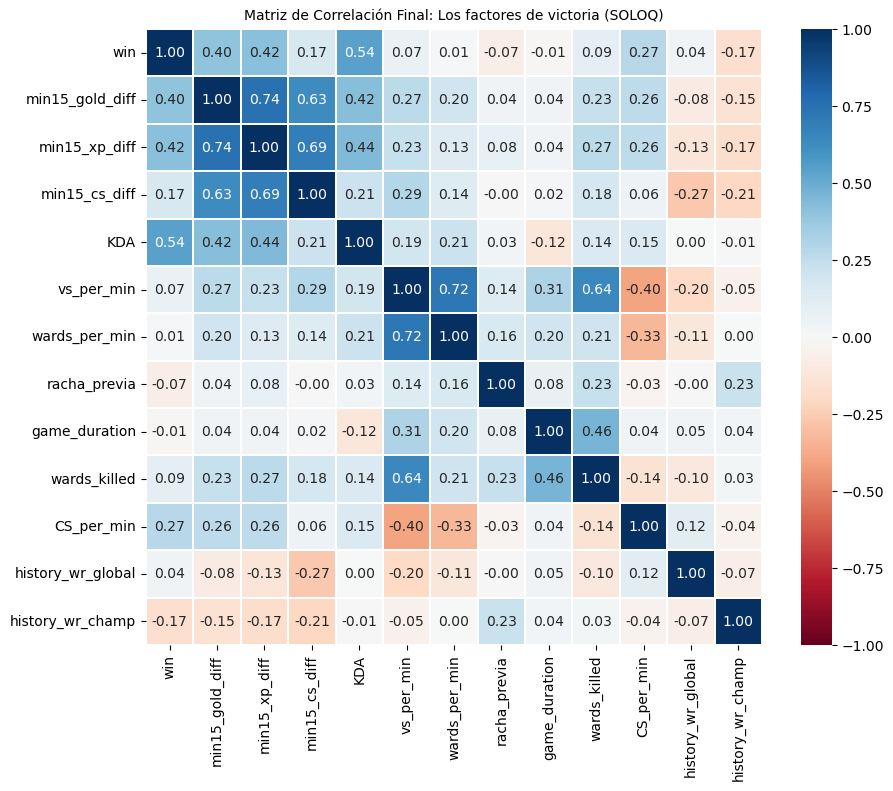

------------------------------------------------------------------------------------------------------------------------
--- 🏆 RANKING DE IMPACTO EN LA VICTORIA (SOLOQ) ---
KDA                  0.540655
min15_xp_diff        0.417166
min15_gold_diff      0.402440
CS_per_min           0.273780
min15_cs_diff        0.171446
history_wr_champ     0.165809
wards_killed         0.094301
racha_previa         0.068459
vs_per_min           0.067332
history_wr_global    0.043408
game_duration        0.010926
wards_per_min        0.009487
Name: win, dtype: float64

--- ¿Relación directa o inversa? (Ayuda + / - Perjudica) ---
KDA                  0.540655
min15_xp_diff        0.417166
min15_gold_diff      0.402440
CS_per_min           0.273780
min15_cs_diff        0.171446
wards_killed         0.094301
vs_per_min           0.067332
history_wr_global    0.043408
wards_per_min        0.009487
game_duration       -0.010926
racha_previa        -0.068459
history_wr_champ    -0.165809
Name: win, dtype: f

In [30]:
corr_matrix = df_analytics_soloq[cols_existing].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,             # Muestra los números
    cmap='RdBu',            # Rojo=Te hace perder, Azul=Te hace ganar
    vmin=-1, vmax=1,        # Fijamos la escala entre -1 y 1
    fmt=".2f",              # 2 decimales
    linewidths=0.3,
    square=True
)
plt.title('Matriz de Correlación Final: Los factores de victoria (SOLOQ)', fontsize=10)
plt.show()

# 4. EL RANKING DE LA VERDAD (Dato Duro)

print("-"*120)
print("--- 🏆 RANKING DE IMPACTO EN LA VICTORIA (SOLOQ) ---")
# Ordenamos por fuerza absoluta (abs) para ver qué pesa más
ranking = corr_matrix['win'].drop('win').abs().sort_values(ascending=False)
print(ranking)

print("\n--- ¿Relación directa o inversa? (Ayuda + / - Perjudica) ---")
print(corr_matrix['win'].drop('win').sort_values(ascending=False))

**Observaciones SOLO Q**

Las variables que generan más impacto en el target son:
- **KDA (relación directa)** = Mientras aumente el KDA, aumentan las victorias.
- **min15_gold_diff (relación directa)** = Mientras aumente la diferencia de oro al minuto 15, aumentan las victorias. Existe una diferencia
considerable entre la correelación de win en Solo Q (0,41 corr) que en Flex (r = 0,24.).    
- **min15_xp_diff (relación directa)** = Mientras aumente la diferencia de XP al minuto 15, aumentan las victorias. Existe una diferencia
considerable entre la correelación de win en Solo Q (0,40 corr) que en Flex (r = 0,23).

- **Sinergia (Economía-Combate)**: Se observa una correlación moderada (r=0.42) entre la ventaja de oro temprana y el KDA final en SoloQ, superior a la observada en Flex (r=0.32). Esto sugiere que en el entorno individual (SoloQ), la capacidad del jugador para convertir el oro (gold_diff) en mejor rendimiento de combate (kda) es más directa y crítica para el resultado. En Flex, esta relación se debilita, indicando que el desempeño de combate depende más de la coordinación grupal que de la ventaja de recursos individual.

**No existen variables que perjudiquen notablemente las victorias en SOLO Q (corr. < 0,2).**

- Confirmamos que hay una leve incidencia estadística negativa de la racha previa en la victoria de las partidas (r=-0.06). Así mismo, el win ratio del campeón utilizado afecta negativamente las victorias (r= -0,16).
- Observamos que no hay demasiada incidencia estadística del vision_score_per_min en la victoria de las partidas (r= 0.06).

### Análisis de correlaciones: GLOBAL

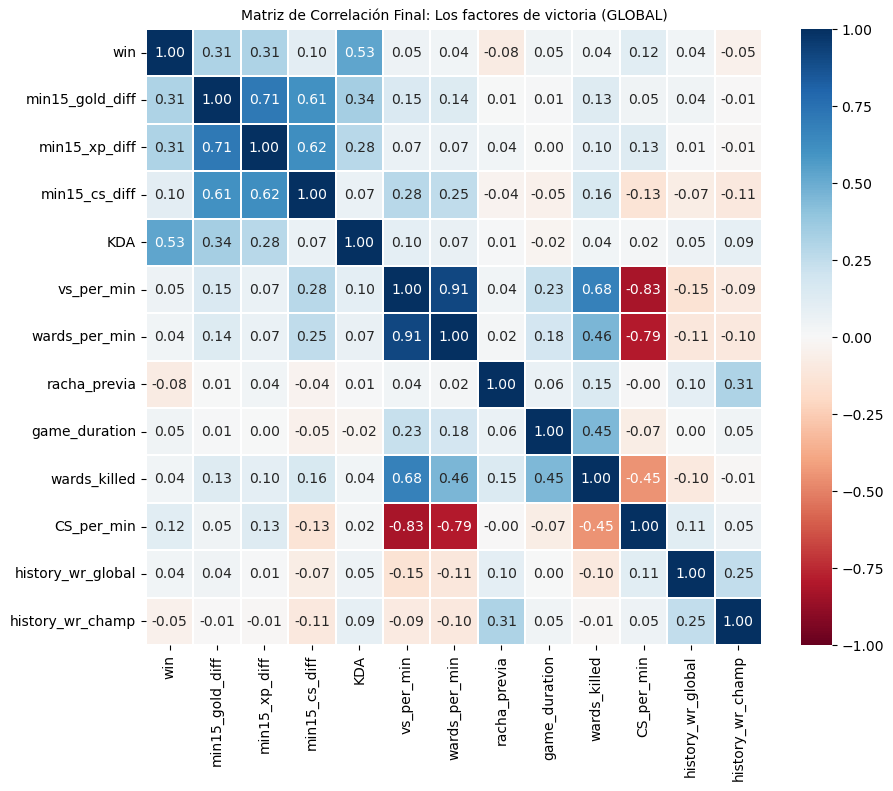

------------------------------------------------------------------------------------------------------------------------
--- 🏆 RANKING DE IMPACTO EN LA VICTORIA (GLOBAL) ---
KDA                  0.526413
min15_xp_diff        0.308711
min15_gold_diff      0.308531
CS_per_min           0.116949
min15_cs_diff        0.103312
racha_previa         0.079052
history_wr_champ     0.053205
vs_per_min           0.047267
game_duration        0.046820
wards_killed         0.037660
wards_per_min        0.036407
history_wr_global    0.035123
Name: win, dtype: float64

--- ¿Relación directa o inversa? (Ayuda + / - Perjudica) ---
KDA                  0.526413
min15_xp_diff        0.308711
min15_gold_diff      0.308531
CS_per_min           0.116949
min15_cs_diff        0.103312
vs_per_min           0.047267
game_duration        0.046820
wards_killed         0.037660
wards_per_min        0.036407
history_wr_global    0.035123
history_wr_champ    -0.053205
racha_previa        -0.079052
Name: win, dtype: 

In [31]:
corr_matrix = df_analytics[cols_existing].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,             # Muestra los números
    cmap='RdBu',            # Rojo=Te hace perder, Azul=Te hace ganar
    vmin=-1, vmax=1,        # Fijamos la escala entre -1 y 1
    fmt=".2f",              # 2 decimales
    linewidths=0.3,
    square=True
)

plt.title('Matriz de Correlación Final: Los factores de victoria (GLOBAL)', fontsize=10)
plt.show()

# 4. EL RANKING DE LA VERDAD (Dato Duro)

print("-"*120)
print("--- 🏆 RANKING DE IMPACTO EN LA VICTORIA (GLOBAL) ---")
# Ordenamos por fuerza absoluta (abs) para ver qué pesa más
ranking = corr_matrix['win'].drop('win').abs().sort_values(ascending=False)
print(ranking)

print("\n--- ¿Relación directa o inversa? (Ayuda + / - Perjudica) ---")
print(corr_matrix['win'].drop('win').sort_values(ascending=False))

**Observación Global**

Las variables que generan más impacto en el target son:
- **KDA (relación directa)** = Mientras aumente el KDA, aumentan las victorias (r = 0,53).
- **min15_gold_diff (relación directa)** = Mientras aumente la diferencia de oro al minuto 15, aumentan las victorias (r = 0,24).    
- **min15_xp_diff (relación directa)** = Mientras aumente la diferencia de XP al minuto 15, aumentan las victorias (r = 0,23).

**No existen variables que perjudiquen notablemente las victorias (corr. < 0,1).**

- Confirmamos que hay una leve incidencia estadística negativa de la racha previa en la victoria de las partidas (r= -0.09). Así mismo, el win ratio del campeón utilizado afecta negativamente las victorias (r= -0,16).
- Observamos que no hay demasiada incidencia estadística del vision_score_per_min en la victoria de las partidas (r= 0.02).

# 📊 RESUMEN: MI DIAGNÓSTICO COMPETITIVO

A partir del análisis descriptivo y de comportamiento realizado sobre mis partidas, he construido mi perfil competitivo actual, identificando tres pilares críticos que definen mi estancamiento o potencial de ascenso:

### 1. Auditoría gestión de recursos de visión
Detecté una **asimetría crítica** entre mi inversión en visión y el win/ratio :
* **En Flex Queue:** Identifiqué una visión ineficiente. Estoy invirtiendo en visión muy por encima del estándar de Diamante/Master, pero esta inversión tiene un **Retorno Nulo ($p > 0.05$)** en mis victorias. **Mi Diagnóstico:** Estoy desperdiciando oro en visión que no estoy aprovechando, lo que retrasa mis picos de poder de combate.
* **En Solo Queue:** Mi estrategia de "Calidad sobre Cantidad" funciona en roles de Carry, pero descubrí un **Déficit Estructural en mi rol de Soporte**, donde mi volumen es inferior al estándar competitivo, afectando negativamente mi control de mapa en un entorno donde la visión sí probó ser significativa para mí **($p > 0.01$)**.

### 2. Auditoría elección champion pool y roles main (SOLOQ y FLEX)
* **Roles main y champeon pool:** Enfoncate en los roles de Jungla, Top y ADC. Sejuani Jarvan IV en Jg (Flex) y Trundle en SoloQ; Malphite e Illaoi con buena proyección en Top (Flex); Ezreal ADC (Flex). Estos picks me permitirán mejorar mis win ratios y  romper la resistencia del matchmaking. Puedes probar LeBlanc en Mid en SoloQ y evita a toda costa el rol de soporte en Flex.

### 3. La Barrera del matchmaking (el "muro de habilidad")
Mi análisis de elasticidad de Matchmaking desmintió la existencia de una "Loss Queue" punitiva en Flex, luego de 4 derrotas el sistema intenta ayudar en recuperar tu mmr. Sin embargo, en Solo Q esto no ocurre, no se presenta un "salvavidas" ante derrotas consecutivas. Por otro lado, el análisis confirma que me enfrento a un **Techo de Habilidad Rígido** luego de una racha de 3 victoria consecutivas. 
* **El fenómeno:** Tras una racha de 3 victorias consecutivas, mi rendimiento individual (KDA, Oro, XP) colapsa ante el aumento de MMR.
* **La causa:** En base al desconocimiento del "ciclo de rachas", se descarta un factor psicológico (Tilt), dado que si estoy en racha de victorias y desconozco el ciclo de rachas, no hay razón para jugar estar tilteado y jugar mal exactamente luego de 3 victorias. Es más razonable que la causa sea que el juego imponga un tope de mmr para evaluar la habilidad mecánica/macro contra oponentes superiores.
* **Juego defensivo racha +3:** Luego de la 3ra victoria consecutiva, lo más recomendable es jugar de manera defensiva, evitar jugadas arriesgadas (mucho riesgo por alto beneficio). En estos casos, es aconsejable jugar más "conservador", evitando situaciones que puedan generar diferencias de oro grandes y optando por generar jugadas seguras (bajo riesgo, bajo beneficio).

### 4. Matriz de Correlación
El análisis de correlación reveló lo siguiente:

1.  **En SoloQ:** Mis juego se deciden en los primeros 15 minutos. La estrategia óptima es **Agresiva/Snowball**. Debo priorizar campeones de *Early/Mid Game* que puedan ganar línea y convertir ese oro en KDA rápidamente, ya que el sistema no perdona las desventajas económicas.

2.  **En Flex:** El juego es permisivo. La estrategia óptima es **Coordinada/Scaling**. Puedo permitirme perder línea levemente si eso garantiza mejor peleas de equipo (*Teamfighting*) tarde, ya que el oro temprano no dicta la sentencia final.

3.  **Gestión de Expectativas:** Debo asumir que tras una racha positiva, la siguiente partida tendrá una probabilidad base de victoria menor debido al ajuste de MMR, independientemente de mi desempeño.


---

## 💡 CONCLUSIONES FINALES Y ACCIONABLES

Tras integrar el análisis descriptivo con la Matriz de Correlación, he refinado mi diagnóstico. Poseo las mecánicas para ascender, pero mi ascenso es frenado por una **mala priorización de factores de victoria**:

### 1. La Jerarquía de la Victoria (KDA > Visión)
La correlación reveló que la ejecución mecánica (**KDA, $r \approx 0.53$**) y la economía temprana (**Oro al 15, $r \approx 0.41$ en SoloQ**) son los predictores dominantes.
* **El Error:** He estado sobrevalorando el control de mapa (Visión $r < 0.10$), tratándolo como un factor primario cuando los datos demuestran que es secundario/higiénico.
* **La Corrección:** Mi foco debe cambiar de "Controlar el Mapa" a **"Dominar la Línea y Ejecutar el Combate"**.

### 2. Ineficiencia de la Visión (Drenaje de Oro)
* **En Flex:** La correlación nula de la visión confirma que mi gasto excesivo en Control Wards es un "impuesto" que yo mismo me cobro, retrasando mis ítems de combate sin generar retorno.
* **En SoloQ:** La alta correlación del *Snowball* (Oro al 15) indica que cada pieza de oro gastada en visión innecesaria reduce mi capacidad de "stompear" la línea, que es la condición de victoria principal en esta cola. Sin embargo, mi inversión en visión tiene más retorno en Solo Q que en flex, ser aún más eficiente entre oro gastado en visión y mantener un buen KDA será un fuerte indicio de victoria.

### 3. Sistema de emparejamiento, rol main y campeones
* **Matchmaking:** La correlación negativa de la **Racha Previa** ($-0.09$) valida matemáticamente el "Freno del Sistema". Debo respetar la 4ta partida como un evento de alta dificultad estadística.
* **Champion Pool:** Debo purgar los campeones que no garantizan ventaja claras según el tipo de cola y rol. En SoloQ debo jugar en base a la capacidad de generar una *Gold Diff* al minuto 15 que sentencie rápidamente una victoria. Mientras que en Flex, la *Gold Diff* al min 15 es menos relevante y debo asegurarme de tener una buena coordinación de peleas en equipo. En ambas colas es muy relevante mantener un buen KDA, por lo que la toma de decisiones es fundamental.

---

### 🚀 ESTRATEGIA FINAL: "SNOWBALL & EFFICIENCY"

Mi plan de ascenso se basa en una reasignación de recursos basada en datos:

1.  **Recorte Presupuestario:** Disminuir dráscticamente la compra de Pinks en Flex y limitarla estrictamente en SoloQ (excepto Support) para acelerar mis *Power Spikes* de daño.
2.  **Prioridad de Early Game:** Utilizar exclusivamente mi "Core Pool" (Sejuani, Jarvan, Ezreal) para asegurar la ventaja de Oro/XP al minuto 15, que es el predictor más fuerte de éxito en solitario.
3.  **Disciplina de Sesión:** Aplicar un *Stop-Loss* estricto y respetar el "Muro de la 4ta Partida" jugando conservadoramente para mitigar la dificultad del MMR.